Retrieved 395979 entries from the catalog.
 ID RAJ2000 DEJ2000 S_G umag gmag ... Mask FWHM-World SG2dphot  ZB chi2ZB ZML
      deg     deg       mag  mag  ...         deg                            
--- ------- ------- --- ---- ---- ... ---- ---------- -------- --- ------ ---
[242.  72.  48.  65.  70.  74.  76.  81.  87.  72.  71.  80.  70.  76.
  53.  36.  49.  33.  27.  26.]
Amount of sources with a separation of 10 arcsec: 209
Total left after removal of the sources: 1418
Amount of sources with a separation of 20 arcsec: 218
Total left after removal of the sources: 1200
Amount of sources with a separation of 30 arcsec: 144
Total left after removal of the sources: 1056
ID                 object
RAJ2000           float64
DECJ2000          float64
K_COR_u           float64
K_COR_g           float64
                   ...   
Resid_Isl_mean    float64
S_Code             object
MK_RA             float64
MK_DEC            float64
Separation        float64
Length: 87, dtype: object
<class '

KeyboardInterrupt: 

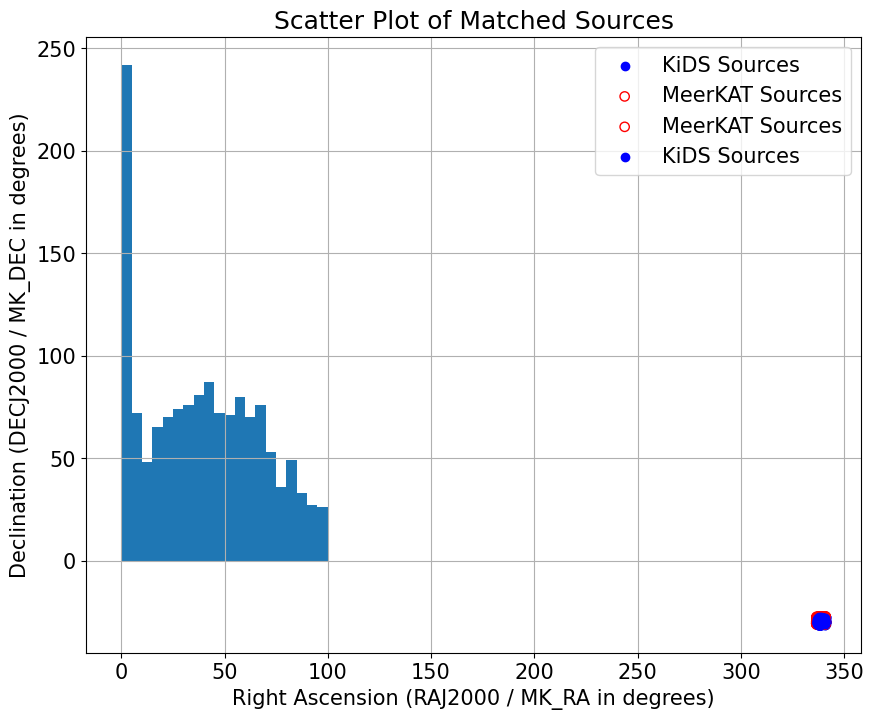

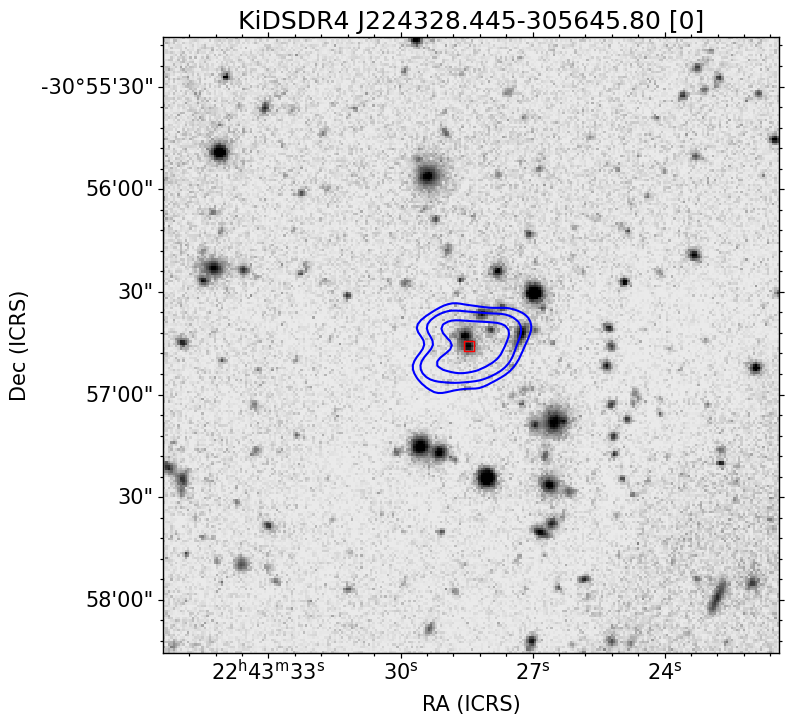

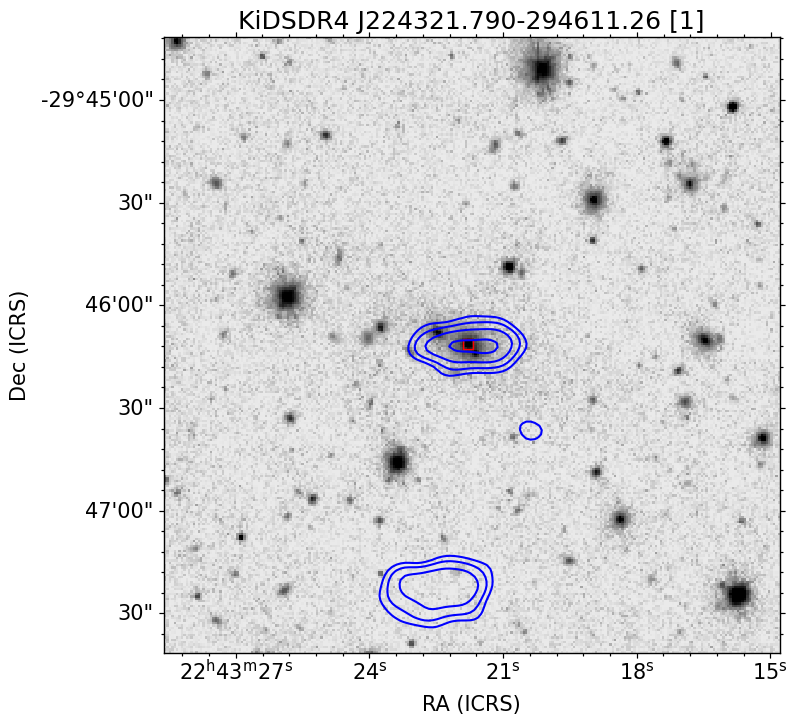

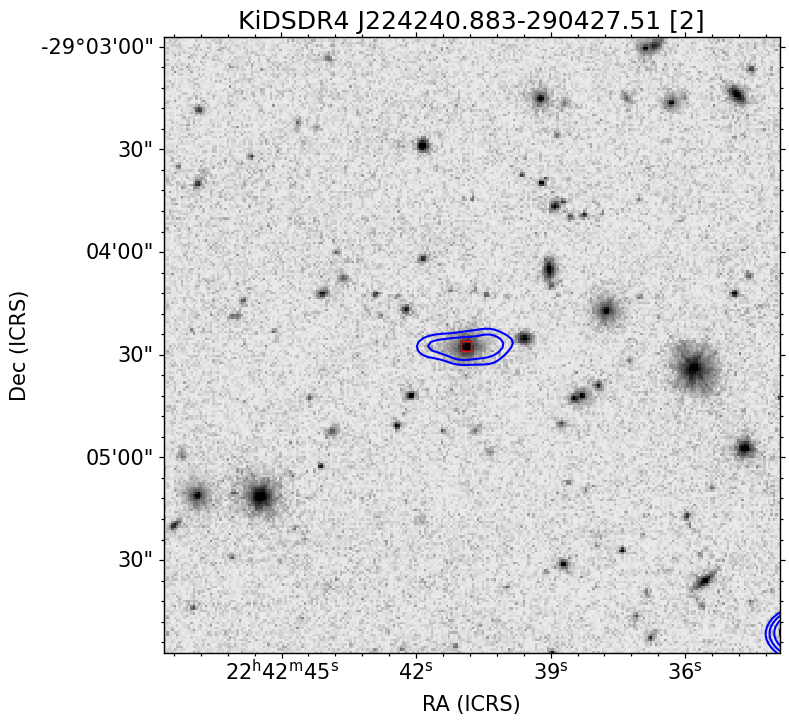

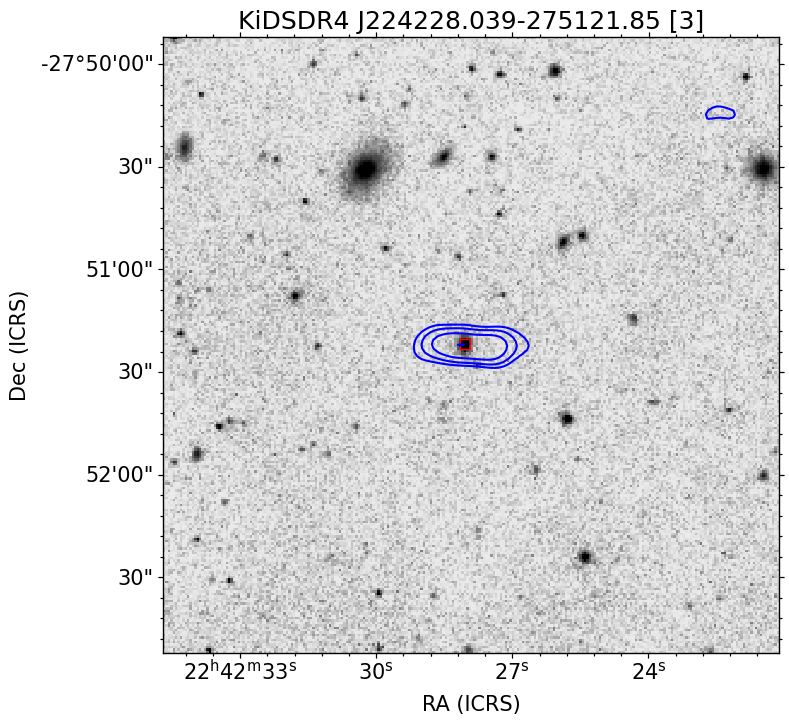

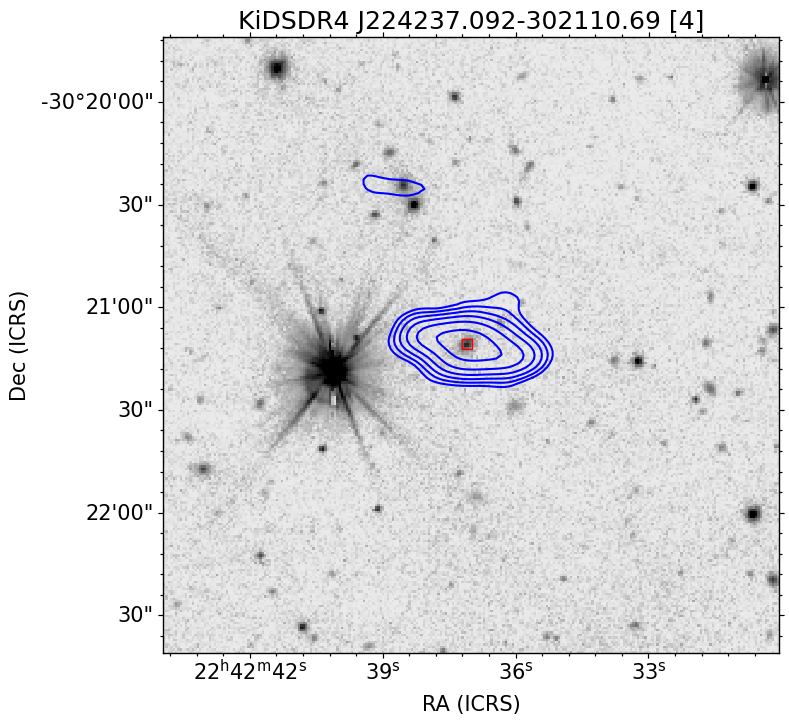

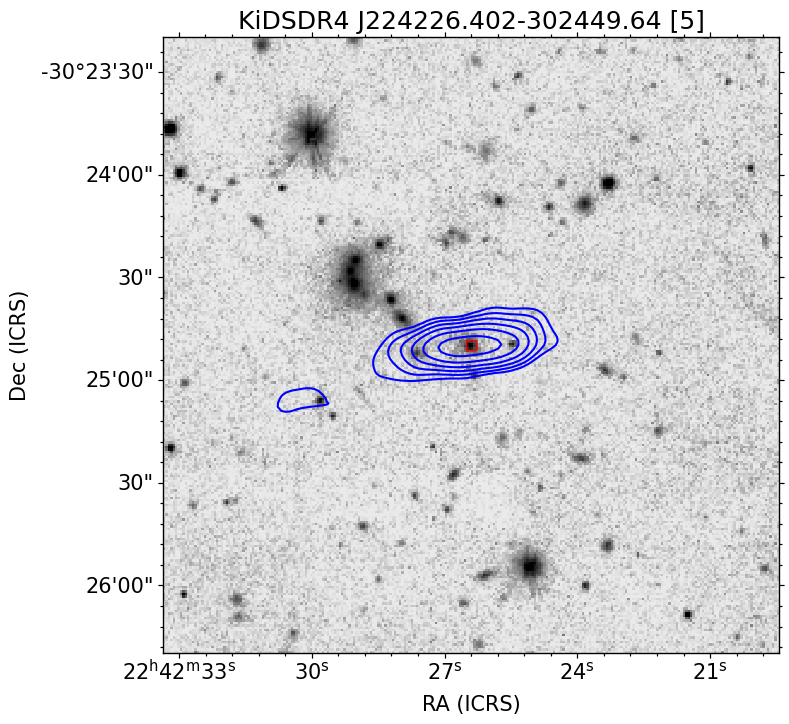

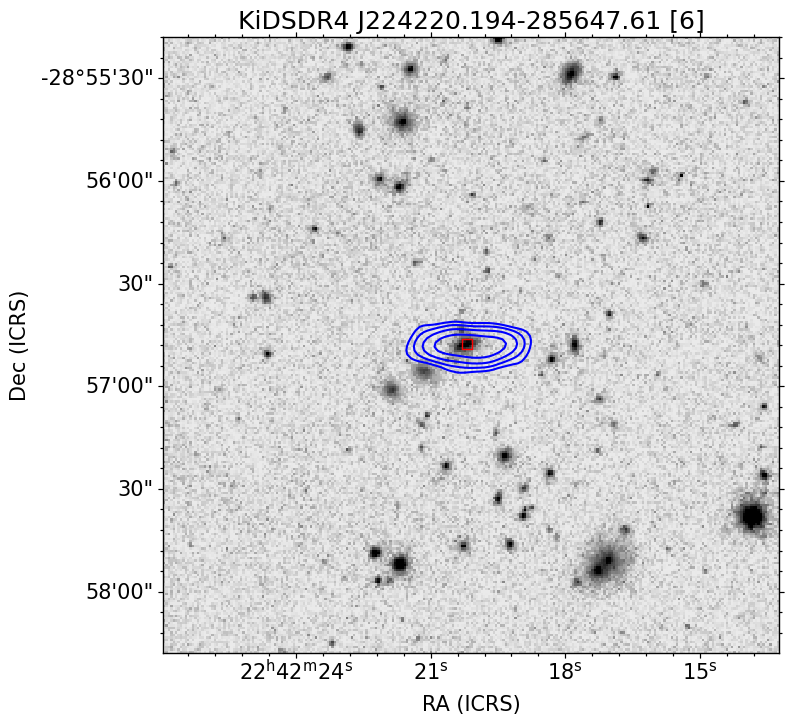

In [3]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt

# Load the CSV file with pandas, specifying that the file uses commas as delimiters
#df = pd.read_csv('Bright')

# Load the KiDS DR4 FITS data and convert to a suitable DataFrame
fits_data = 'KiDS_DR4_brightsample_LePhare.fits'
with fits.open(fits_data) as hdul:
    data = hdul[1].data
    df = Table(data).to_pandas()

# Filter KiDS data based on RA and DEC ranges
fil_df = df[(df['RAJ2000'] >= 336) & (df['RAJ2000'] <= 342) & (df['DECJ2000'] >= -32) & (df['DECJ2000'] <= -27)]
fil_df = fil_df.reset_index(drop=True)

# Load the MeerKAT data and convert to a DataFrame
fits_mk = 'D01-05_LOC22_im-di2_smallFacet.deeper.DI.int.restored.pybdsf.srl.fits'
with fits.open(fits_mk) as hdul:
    data_mk = hdul[1].data
    df_mk = Table(data_mk).to_pandas()
df_mk = df_mk.reset_index(drop=True)

# Convert RA and DEC columns to SkyCoord objects for distance calculations
coords1 = SkyCoord(ra=fil_df['RAJ2000'].values * u.deg, dec=fil_df['DECJ2000'].values * u.deg)
coords2 = SkyCoord(ra=df_mk['RA'].values * u.deg, dec=df_mk['DEC'].values * u.deg)

# Find the closest KiDS source for each MeerKAT source and store matches
closest_matches = []

for idx2, mk_coord in enumerate(coords2):
    # Calculate the angular separation and find the closest KiDS source
    sep = mk_coord.separation(coords1)
    closest_idx = np.argmin(sep)
    closest_separation = sep[closest_idx].deg

    # Get data for the closest KiDS source and current MeerKAT source
    kids_info = fil_df.iloc[closest_idx].to_dict()
    meerkat_info = df_mk.iloc[idx2].to_dict()

    # Combine information and add additional details
    match_info = {**kids_info, **meerkat_info}
    match_info['MK_RA'] = df_mk['RA'].iloc[idx2]
    match_info['MK_DEC'] = df_mk['DEC'].iloc[idx2]
    match_info['Separation'] = closest_separation

    closest_matches.append(match_info)

# Convert the list of closest matches to a DataFrame
closest_matches_df = pd.DataFrame(closest_matches)

# Define the radius for the query (if needed)
radius = 4 * u.deg
Vizier.ROW_LIMIT = -1  # Retrieve all rows within range
coords = SkyCoord(ra=339.0, dec=-29.5, unit=(u.deg, u.deg), frame='icrs')  # Example coordinates
object_ids = df['ID'].tolist()  # Replace with your actual list of object IDs
result = Vizier.query_region(coords, radius=radius, catalog="J/A+A/632/A56/catalog")  # Replace with your catalog
data = result[0]  # Get the first table from the results
print(f"Retrieved {len(data)} entries from the catalog.")

# Convert the 'ID' column to a regular NumPy array for filtering
id_column = data['ID'].data  # This is still a MaskedColumn
id_array = id_column.filled()  # Fill masked values with NaN

# Filter the DataFrame to keep only the rows with IDs in your list using np.isin
filtered_data = data[np.isin(id_array, object_ids)]  # Use np.isin for filtering
print(filtered_data)

# Create a scatter plot of matched sources
plt.figure(figsize=(10, 8))

# Plot KiDS sources
plt.scatter(closest_matches_df['RAJ2000'], closest_matches_df['DECJ2000'], 
            color='blue', label='KiDS Sources')

# Plot MeerKAT sources
plt.scatter(closest_matches_df['MK_RA'], closest_matches_df['MK_DEC'], s=45, 
            edgecolor='red', facecolor='none', label='MeerKAT Sources')

# Adding labels and title
plt.title('Scatter Plot of Matched Sources')
plt.xlabel('Right Ascension (RAJ2000 / MK_RA in degrees)')
plt.ylabel('Declination (DECJ2000 / MK_DEC in degrees)')
plt.legend()
plt.grid(True)

# Histogram of separation distances
data_matched = plt.hist(closest_matches_df['Separation'] * 3600, bins=20, range=(0, 100))
print(data_matched[0])

# Filtering closest matches for different separations
closest_matches_df1 = closest_matches_df[closest_matches_df['Separation'] < 3 / 3600]
print('Amount of sources with a separation of 10 arcsec:', len(closest_matches_df1))

# Removing these sources from the original dataset
closest_matches_df = closest_matches_df[~closest_matches_df.index.isin(closest_matches_df1.index)].reset_index(drop=True)
print('Total left after removal of the sources:', len(closest_matches_df))
closest_matches_df1 = closest_matches_df1.reset_index(drop=True)

# Finding matches for 20 arcseconds
closest_matches_df2 = closest_matches_df[closest_matches_df['Separation'] < 20 / 3600]
print('Amount of sources with a separation of 20 arcsec:', len(closest_matches_df2))

# Removing these sources from the original dataset
closest_matches_df = closest_matches_df[~closest_matches_df.index.isin(closest_matches_df2.index)].reset_index(drop=True)
closest_matches_df2 = closest_matches_df2.reset_index(drop=True)
print('Total left after removal of the sources:', len(closest_matches_df))

# Finding matches for 30 arcseconds
closest_matches_df3 = closest_matches_df[closest_matches_df['Separation'] < 30 / 3600]
print('Amount of sources with a separation of 30 arcsec:', len(closest_matches_df3))

# Removing these sources from the original dataset
closest_matches_df = closest_matches_df[~closest_matches_df.index.isin(closest_matches_df3.index)].reset_index(drop=True)
closest_matches_df3 = closest_matches_df3.reset_index(drop=True)
print('Total left after removal of the sources:', len(closest_matches_df))

# Scatter plot of filtered matches
plt.scatter(closest_matches_df1['MK_RA'], closest_matches_df1['MK_DEC'], s=45, edgecolor='red', 
            facecolor='none', label='MeerKAT Sources')
plt.scatter(closest_matches_df1['RAJ2000'], closest_matches_df1['DECJ2000'], color='blue', label='KiDS Sources')

# Adding labels and title
plt.title('Scatter Plot of Matched Sources')
plt.xlabel('Right Ascension (RAJ2000 / MK_RA in degrees)')
plt.ylabel('Declination (DECJ2000 / MK_DEC in degrees)')
plt.legend()
plt.grid(True)

# Display the data types of the DataFrame
print(closest_matches_df.dtypes)

# Cleaning the 'ID' column
closest_matches_df1['ID'] = closest_matches_df1['ID'].astype(str).str.strip('"')
closest_matches_df2['ID'] = closest_matches_df2['ID'].astype(str).str.strip('"')
closest_matches_df3['ID'] = closest_matches_df3['ID'].astype(str).str.strip('"')

# Save DataFrames to text files
closest_matches_df1.to_csv('closest_matches_df1.txt', sep=',', index=False)
closest_matches_df2.to_csv('closest_matches_df2.txt', sep=',', index=False)
closest_matches_df3.to_csv('closest_matches_df3.txt', sep=',', index=False)

from astroquery.hips2fits import hips2fits
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import astropy.units as u
from astropy.coordinates import Longitude, Latitude, Angle
from astropy.wcs import WCS
from astropy.io import fits
import numpy as np
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import pandas as pd
import aplpy

# --------------------------------------------------------------------------------------------- 

# This is a script that generates a smaller .fits cutout image from a larger mosciac file.
# Change the .fits files to the name of your choice and give it a txt file with a list of coordiniates of your sources.
# This makes small .fits cutouts that can be used to produce overlays using MAKEOVERLAYS.py

# Requires pyfits and worldpos 

# --------------------------------------------------------------------------------------------- 
from astropy.io import fits as pyfits
from astropy.io import fits
# import pyfits
import os
import copy
import numpy as np 
# import pywcs
from astropy.wcs import WCS 
# import worldpos # Contains definition of RA,Dec to x,y conversion


fits_file = 'D01-05_LOC22_im-di2_smallFacet.deeper.DI.int.restored.fits'
out_file= 'cutout1.fits'


fits_data = pyfits.getdata(fits_file,0)
header = pyfits.getheader(fits_file)
image_data = fits_data[0][0]
import numpy as np

ID, RA, Dec = np.loadtxt('closest_matches_df1.txt', unpack=True, usecols=[0, 1, 2], delimiter=',',skiprows=1, dtype=[('ID', '|S50'), ('MK_RA', 'f8'), ('MK_DEC', 'f8')])

from astropy.coordinates import SkyCoord 
import numpy as np
# ID,RA,Dec = np.loadtxt('../datainput/D01-05_LOC22_S.txt', unpack=True, usecols=[0,1,2], dtype=[('ID','|S30'),('RA','f8'),('dec','f8')])
c = SkyCoord(RA, Dec, unit="deg")  # defaults to ICRS frame
# wcs = worldpos.wcs(fits_file, ext=0, rot='CROTA2', cd=False) # crota2 assumed to be zero (i.e. image has no rotation wrt sky)
# x,y = wcs.sky2xy(RA, Dec) # POS_X, POS_Y
#https://github.com/aplpy/aplpy/issues/423
f = fits.open(fits_file)
w = WCS(f[0].header, naxis=2)
# print(w)
x, y = w.world_to_pixel(c)

# Pixel numbers
pixel_x = np.rint(x).astype('i') # Rounding to the nearest integer, then ensuring type is changed from float to integer
pixel_y = np.rint(y).astype('i')
# print(pixel_x, pixel_y)
def cutout(file,xc,yc,name,xw=100,yw=100,units='pixels',JPEGFolder = "WESTTEST",clobber=True):
    """
    Inputs:
        file  - .fits filename or pyfits HDUList (must be 2D)
        xc,yc - x and y coordinates in the fits files' coordinate system
        xw,yw - x and y width
        units - specify units to use: either pixels or wcs
        outfile - optional output file
    """

    if isinstance(file,str):
        file = pyfits.open(file)
        opened=True
    elif isinstance(file,pyfits.HDUList):
        opened=False
    else:
        raise Exception("cutout: Input file is wrong type (string or HDUList are acceptable).")

    head = file[0].header
    # if head['NAXIS'] > 2:
    #     raise Exception("Too many (%i) dimensions!" % head['NAXIS'])
    try:
        cd1 = head['CDELT1']
        cd2 = head['CDELT2']
    except:
        try:
            cd1 = head['CD1_1']
            cd2 = head['CD2_2']
        except:
            raise Exception("No CD or CDELT keywords in header")

    lonarr = ((np.arange(head['NAXIS1'])-head['CRPIX1'])*cd1 + head['CRVAL1'] )
    latarr = ((np.arange(head['NAXIS2'])-head['CRPIX2'])*cd2 + head['CRVAL2'] )

#wcs = pywcs.WCS(head)

    #xx = np.argmin(np.abs(xc-lonarr))
    #yy = np.argmin(np.abs(yc-latarr))
    #xx,yy = wcs.wcs_sky2pix(xc,yc,0)


    if os.path.exists(JPEGFolder) == False:
            os.makedirs(JPEGFolder)
    
    
    for n,x,y in zip(name,xc,yc):
        naxis1=head['NAXIS1']
        naxis2=head['NAXIS2']       
        crpix1=head['CRPIX1']
        crpix2=head['CRPIX2']
        # print('crpix',naxis1, naxis2,crpix1, crpix2)
 
        if units=='pixels':
            xmin,xmax = np.max([0,x-xw]),np.min([naxis1,x+xw])
            ymin,ymax = np.max([0,y-yw]),np.min([naxis2,y+yw])
            # print('xmin,xmax, ymin, ymax', xmin, xmax, ymin, ymax)
        elif units=='wcs':
            xmin,xmax = np.max([0,x-xw/np.abs(cd1)]),np.min([naxis1,x+xw/np.abs(cd1)])
            ymin,ymax = np.max([0,y-yw/np.abs(cd2)]),np.min([naxis2,y+yw/np.abs(cd2)])
        else:
            raise Exception("Can't use units %s." % units)

        if xmax < 0 or ymax < 0:
            raise Exception("Coordinate is outside of map.")

        img = file[0].data[0, 0, ymin:ymax,xmin:xmax]
        # print(img.shape)
        crpix1-=xmin
        crpix2-=ymin
        naxis1=img.shape[1]
        naxis2=img.shape[0]
        # print('crpix', naxis1, naxis2,crpix1, crpix2)
	
        newhead=copy.deepcopy(head)
        newhead['CRPIX1']=crpix1
        newhead['CRPIX2']=crpix2
        newhead['NAXIS1']=naxis1
        newhead['NAXIS2']=naxis2
        newfile = pyfits.PrimaryHDU(data=img,header=newhead)
        print(type(n), n)
        outfile= JPEGFolder+os.path.sep+n.decode('UTF-8')+'.fits'
        if isinstance(outfile,str):
            newfile.writeto(outfile,overwrite=clobber)

       
       
    #if opened:
     #   file.close()

cutout1 = cutout(file=fits_file,xc=pixel_x,yc=pixel_y,xw=1000,yw=1000,units='pixels',name=ID,clobber=True)


def get_background_variance(data,sigma_clip=5.0,tolerance=0.01):
    """Compute the variance by iteratively removing outliers greater than a given sigma
    until the mean changes by no more than tolerance.
    (function stolen from TomM)

    Inputs
    ------
    data - 1d numpy array of data to compute variance
    sigma_clip - the amount of sigma to clip the data before the next iteration
    tolerance - the fractional change in the mean to stop iterating

    Outputs
    -------
    variance - the final background variance in the sigma clipped image
    """
    #Initialise diff and data_clip and mean and std
    diff = 1
    mean = np.nanmean(data)
    data_clip = data
    while diff > tolerance:
        data_clip = data_clip[np.abs(data_clip)<mean+sigma_clip*np.nanstd(data_clip)]
        newmean = np.nanmean(data_clip)
        diff = np.abs(mean-newmean)/(mean+newmean)
        mean = newmean
    return np.nanvar(data_clip)


mkcat = np.genfromtxt('closest_matches_df1.txt', 
                      delimiter=',',      # Adjust the delimiter if necessary
                      dtype=None,        # Allow mixed data types
                      encoding=None,     # Use 'utf-8' or None depending on your data
                      names=True)        # Load column names as field names
!mkdir cutout_mk
!mkdir image_overlay
!cp -r ./WESTTEST/* cutout_mk

target_num = mkcat['ID']  # Access the 'ID' column directly


for ii in range(mkcat.shape[0]):
    target_name = str(target_num[ii])
    target_RA = mkcat['MK_RA'][ii] * u.deg  # Access the RA column
    target_DEC = mkcat['MK_DEC'][ii] * u.deg  # Access the DEC column
    print(target_RA, target_DEC)

    # Find the optical part from cutout server
    hips = 'CDS/P/KiDS/DR5/color-gri'  # The catalogue we'll use for KIDS
    result = hips2fits.query(
       hips=hips,
       width=256,  # pixels
       height=256,
       ra=Longitude(target_RA),
       dec=Latitude(target_DEC),
       fov=Angle(0.05 * u.deg),  # field of view (radius)
       projection="SIN",
       get_query_payload=False,
       format='fits',  # use FITS format to work with WCS
       min_cut=0,
       max_cut=100,
       cmap=Colormap('viridis'),
    )
    
    # Load the KiDS catalogue from Vizier
    #Vizier.ROW_LIMIT = -1  # the number sources stars or galaxies
    #coords = SkyCoord(ra=target_RA, dec=target_DEC, frame='icrs')
    #radius = 0.35 * u.deg
    
    # Query the specific catalog for the object with this ID
    
    #result1 = Vizier.query_constraints(catalog='J/A+A/632/A56/catalog', ID=mkcat['ID'][ii])

    '''
    table = result1[0]  # Access the first table in the result
    
    table.write('typ_so.csv', format='csv', overwrite=True)
    # Access specific values from the first row
    pGALAXY_value = table['pGALAXY'][0]
    pSTAR_value = table['pSTAR'][0]
    pQSO_value = table['pQSO'][0]
    #Determine the type based on the probability values
        
    if pSTAR_value > 0.99:
        typ_so = 'STAR'
    elif pQSO_value > 0.99:
        typ_so = 'QSO'
    elif pGALAXY_value > 0.99:
        typ_so = 'GALAXY'
    else:
        typ_so = 'Nothing found'  
    '''
    
    df_clo = pd.read_csv('closest_matches_df1.txt', delimiter=',')
    
    # Extract the RA and DEC for the closest matches
    closest_matches_RA = df_clo['RAJ2000'][ii]
    closest_matches_DEC = df_clo['DECJ2000'][ii]
        
    # Convert to astropy quantities
    closest_matches_RA = closest_matches_RA * u.deg
    closest_matches_DEC = closest_matches_DEC * u.deg

    
    # Example: converting to lists for plotting
    xG = closest_matches_RA
    yG = closest_matches_DEC
        

    # Get rid of vestigial image header parameters
    fitsfile = 'cutout_mk/%s.fits' % target_name
    HF_fits = fits.open(fitsfile, mode='update')
    HF_header = HF_fits[0].header
    
    remove_list = ['WCSAXES', 'CTYPE3', 'CRVAL3', 'CDELT3', 'CRPIX3', 'CTYPE4', 'CRVAL4', 'CDELT4', 'CRPIX4', 'CUNIT4']
    
    for key in remove_list:
        if key in HF_header:
            HF_header.remove(key)
    HF_fits.close()
    
    # Get data variance for calculating contour levels
    fitsimage = fits.open(fitsfile)
    data = fitsimage[0].data
    sigma = np.sqrt(get_background_variance(data.flatten()))
    #HF_levels = np.logspace(np.log10(5.0 * sigma), np.log10(1 * np.nanmax(data)), num=10)  
    HF_levels = np.logspace(np.log10(3.0 * sigma), np.log10(45 * sigma), num=7)  
    
    #make figure
    plt.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(8, 8))
    
    f = aplpy.FITSFigure(result, slices=[0], figure=fig)
    # f = aplpy.FITSFigure(fitsfile, figure=fig)
    f.show_grayscale(invert='True') 
    f.show_contour(fitsfile,slices=[0,0],levels=HF_levels,colors='b',overlap=True,smooth=1)
    f.show_markers(xG,yG,marker='s', edgecolor='r',s=50,linewidths=1)
    ti= target_name+'['+str(ii)+']'
    plt.title(ti)
    
    SUFFIX = '-MeerKLASS_KiDS'    
    fig.savefig('image_overlay/{0}{1}.png'.format(target_name, SUFFIX))
    